# Python Data Extraction

In [190]:
from msc_code.scripts.notebook_setup import *

### Case Report Dataframe

In [191]:
case_report_column_headers = [
    "Study_ID",
    "Patient_ID",
    "Age_Yrs",  # Numeric. Age in years
    "Gender",    # Categorical. Male/Female
    "Motivation_Intent_To_Harm", # Categorical. Y/N/UK
    "Motivation_Protest",  # For betterment of or change of conditions, to influence others: Y/N/UK
    "Motivation_Other",    # Other Motivation: Text/string
    "Object_Button_Battery", # Y/N/UK
    "Object_Magnetic",  # Y/N/UK
    "Object_Long", # Y/N/UK. >6cm
    "Object_Sharp", # Y/N/UK
    "Object_Multiple", # Y/N/UK
    "Object_Other", # String. Notes or comments or values.
    "Outcome_Endoscopy",# Y/N/UK
    "Outcome_Surgery",  # Y/N/UK. True if Surgical intervention undertaken.
    "Outcome_Death",    # Y/N/UK
    "Outcome_Injury_Needing_Intervention", # Y/N/UK
    "Outcome_Perforation",  # Y/N/UK
    "Outcome_Obstruction",  # Y/N/UK
    "Outcome_Other",    # Y/N/UK
    "Comments"  # Y/N/UK
]

In [192]:
case_report_data_extraction = pd.DataFrame(columns=case_report_column_headers)

In [193]:
case_report_data_extraction.to_csv("/".join([RAW_DATA_DIR, "data_extraction", "case_report_data_extraction_template.csv"]), index=False)

### Study Data

In [194]:
study_data_columns = [
    "Study_ID",
    "Publication_Year",
    "First_Author",
    "DOI",
    "Exclude",
    "Bibliography_Searched",
    "Comments"
    ""
]

## Import included papers

In [195]:
import_path = os.path.join(PROC_DATA_DIR, 'full_text_screen')

ft_included = pd.read_csv('/'.join([import_path, 'full_text_screen_included_final.csv']))

ft_start = pd.read_csv('/'.join([import_path, 'full_text_screen_start.csv']))

ft_start = ft_start.rename(columns={
    'id': 'Study_ID'
})

In [196]:
ft_start.columns

Index(['Study_ID', 'Publication Year', 'Authors', 'Title', 'Publication Title',
       'Database', 'Exclude', 'Reason ID', 'Paediatric', 'Intention Reported',
       'Deliberate Intention', 'Unclear', 'Accessed', 'Comments'],
      dtype='object')

In [197]:
data_extraction_start = pd.DataFrame({
    'Study_ID': ft_included['Study_ID'],    # Unique Study_ID
    'First_Author': np.nan,                     # First Author: Lastname, F.
    'Publication_Year': np.nan,     
    'Authors': np.nan, 
    'Title': None, 
    'Publication_Title': np.nan,
    'Study_Design': np.nan,
    'Study_Setting': np.nan, 
    'DOI': np.nan,
    'Data_Extracted': np.nan,
    'Bibliograph_Searched': np.nan,
    'Notes': np.nan,
})

ft_start = ft_start.rename(columns={
    'id': 'Study_ID'
})

titles = ft_start[['Study_ID', 'Title']]

data_extraction_start = pd.merge(
    data_extraction_start.drop(columns=['Title']),  # drop the empty Title first
    titles,
    on='Study_ID',
    how='left'
)

data_extraction_start = data_extraction_start[['Study_ID', 'First_Author', 'Publication_Year', 'Authors',
       'Publication_Title', 'Title', 'Study_Design', 'Study_Setting', 'DOI', 'Notes']]

export_path = os.path.join(PROC_DATA_DIR, 'data_extraction')
data_extraction_start.to_csv('/'.join([export_path, 'data_extraction_start.csv']), index=False)

In [198]:
import_path = os.path.join(RAW_DATA_DIR, 'data_extraction')
study_data = pd.read_excel('/'.join([RAW_DATA_DIR, 'data_extraction', 'data_extraction_start.xlsx']))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


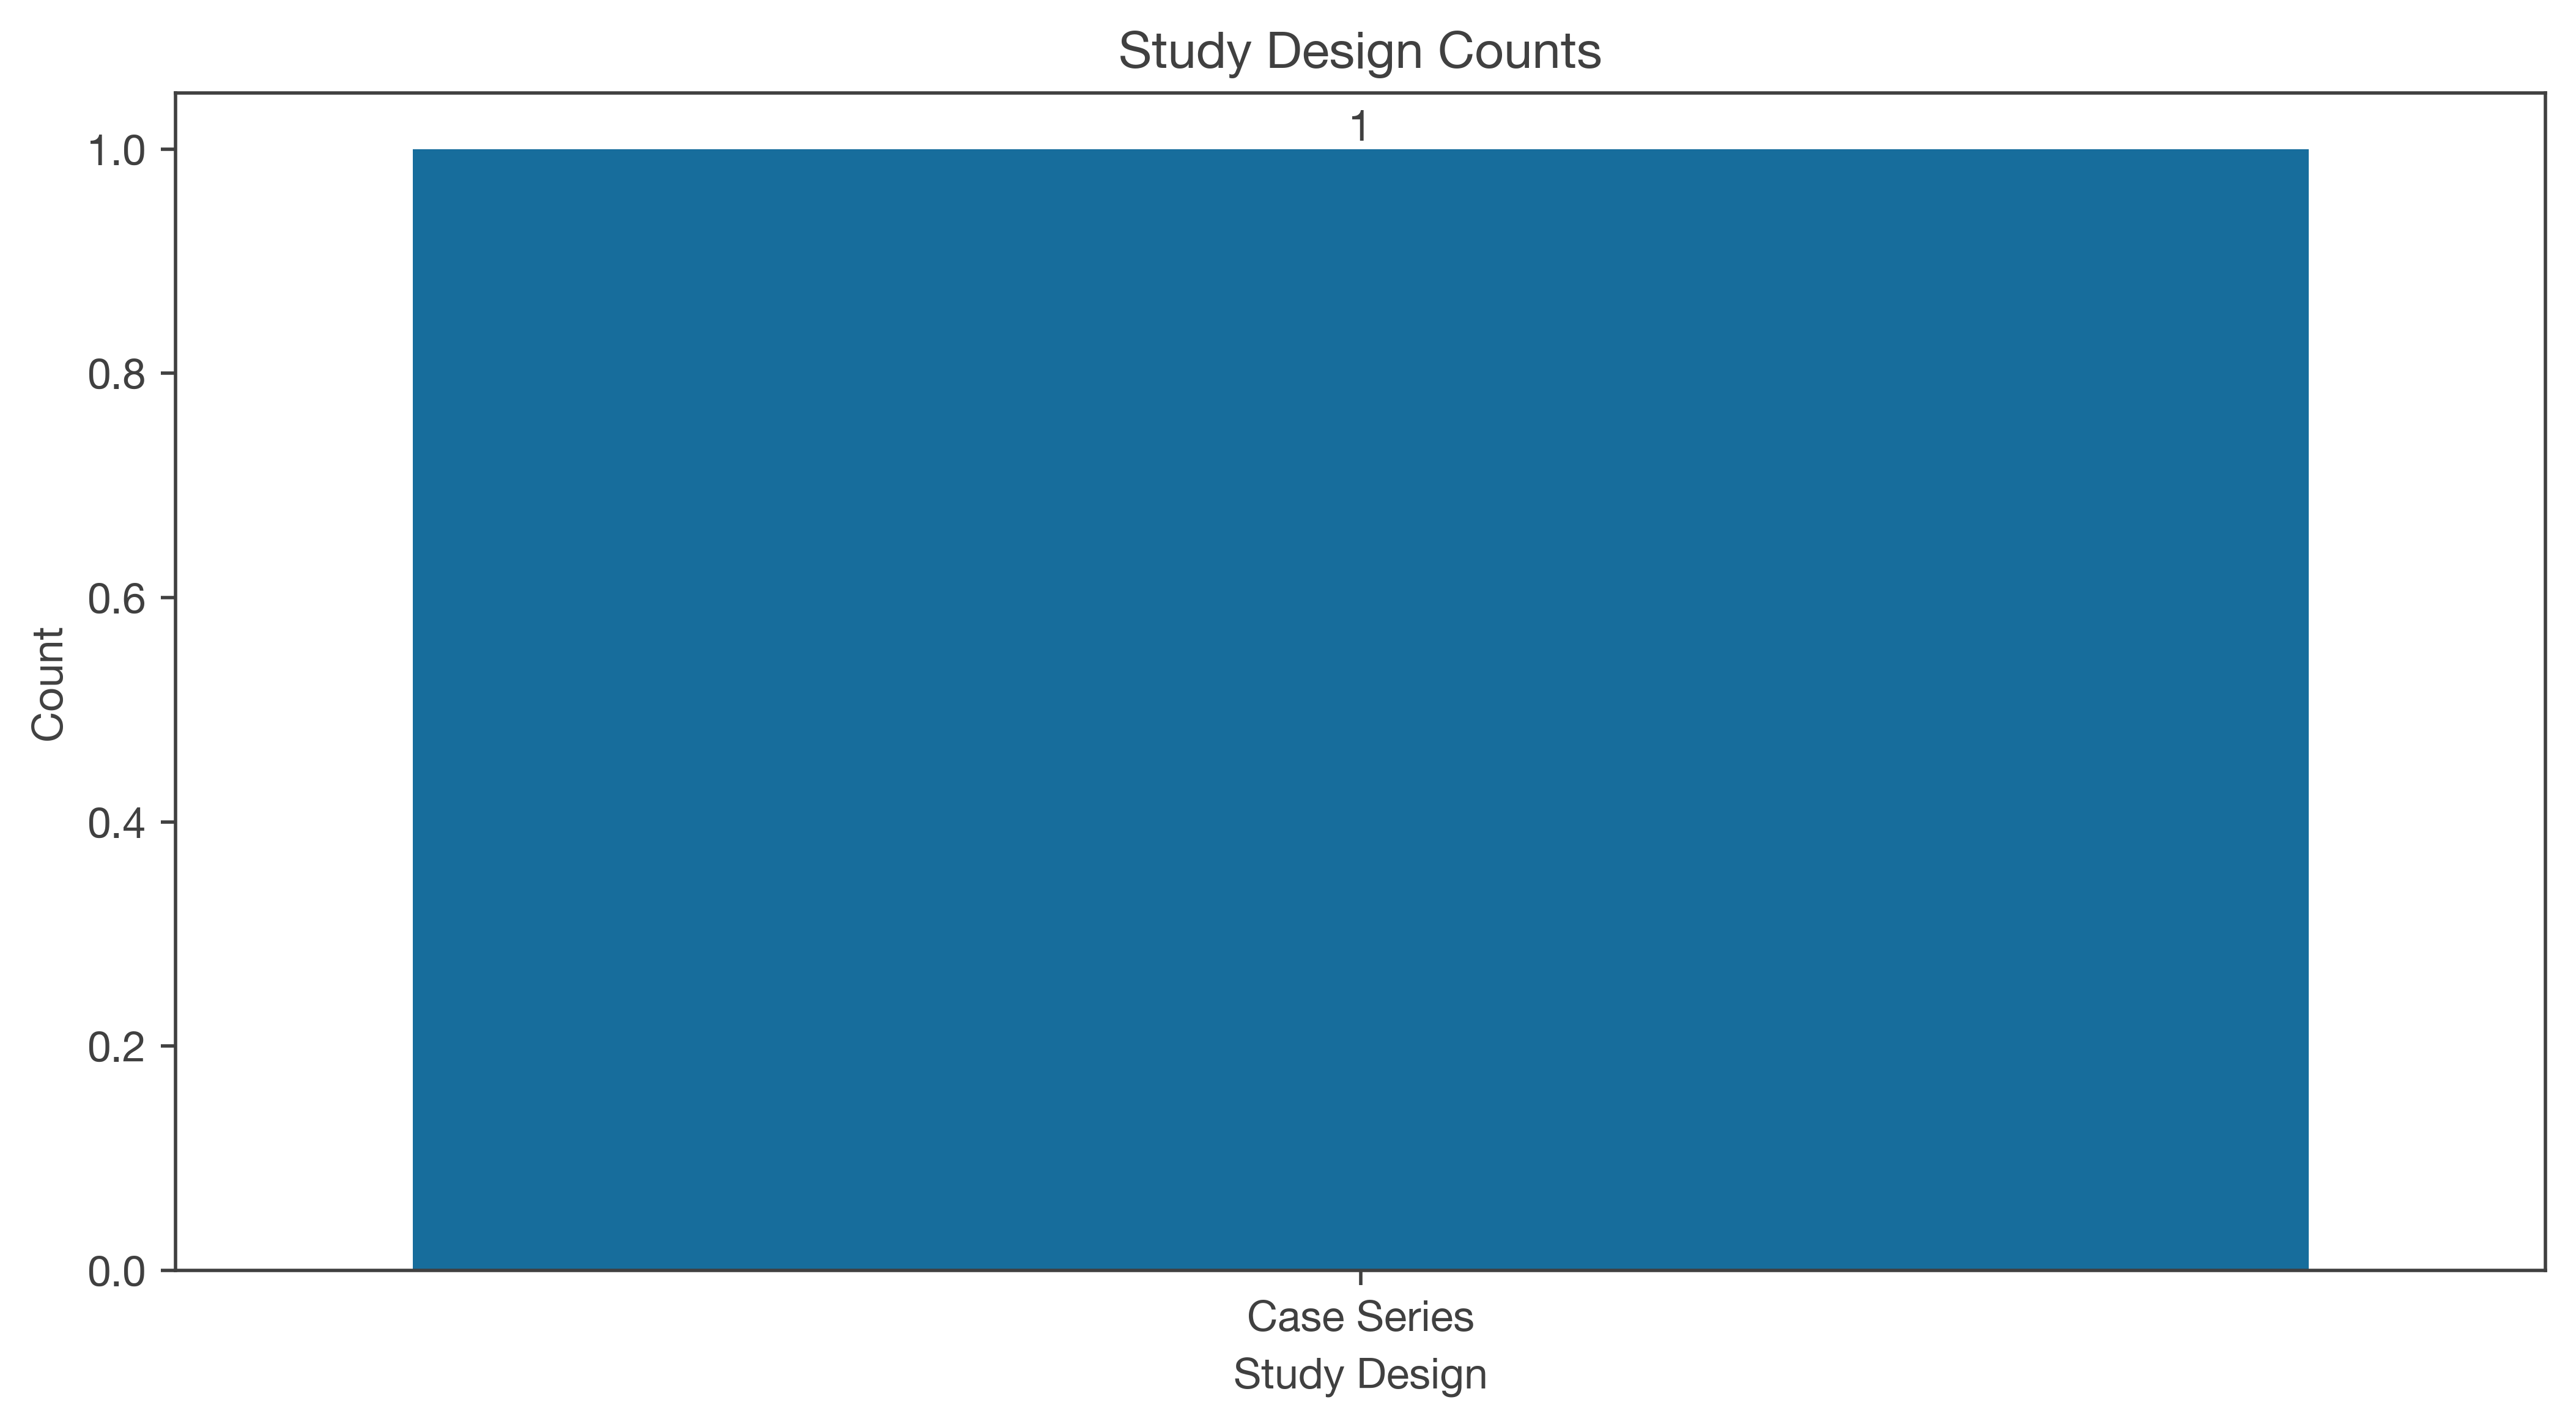

In [199]:
plot_data = study_data['Study_Design'].value_counts().reset_index()
plot_data.columns = ['Study Design', 'Count']
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=plot_data, x='Study Design', y='Count', palette='colorblind')

# Set title and labels
ax.set(title='Study Design Counts', xlabel='Study Design', ylabel='Count')

# Add labels to the top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.savefig('/'.join([FIG_DIR, "study_design_barplot.png"]), format='png', dpi=300)
# Show plot
plt.show()


In [200]:
data_extraction_progess = study_data['Data_Extracted'].value_counts().reset_index()
data_extraction_progess

,Data_Extracted,count
0,N,114
1,Y,2


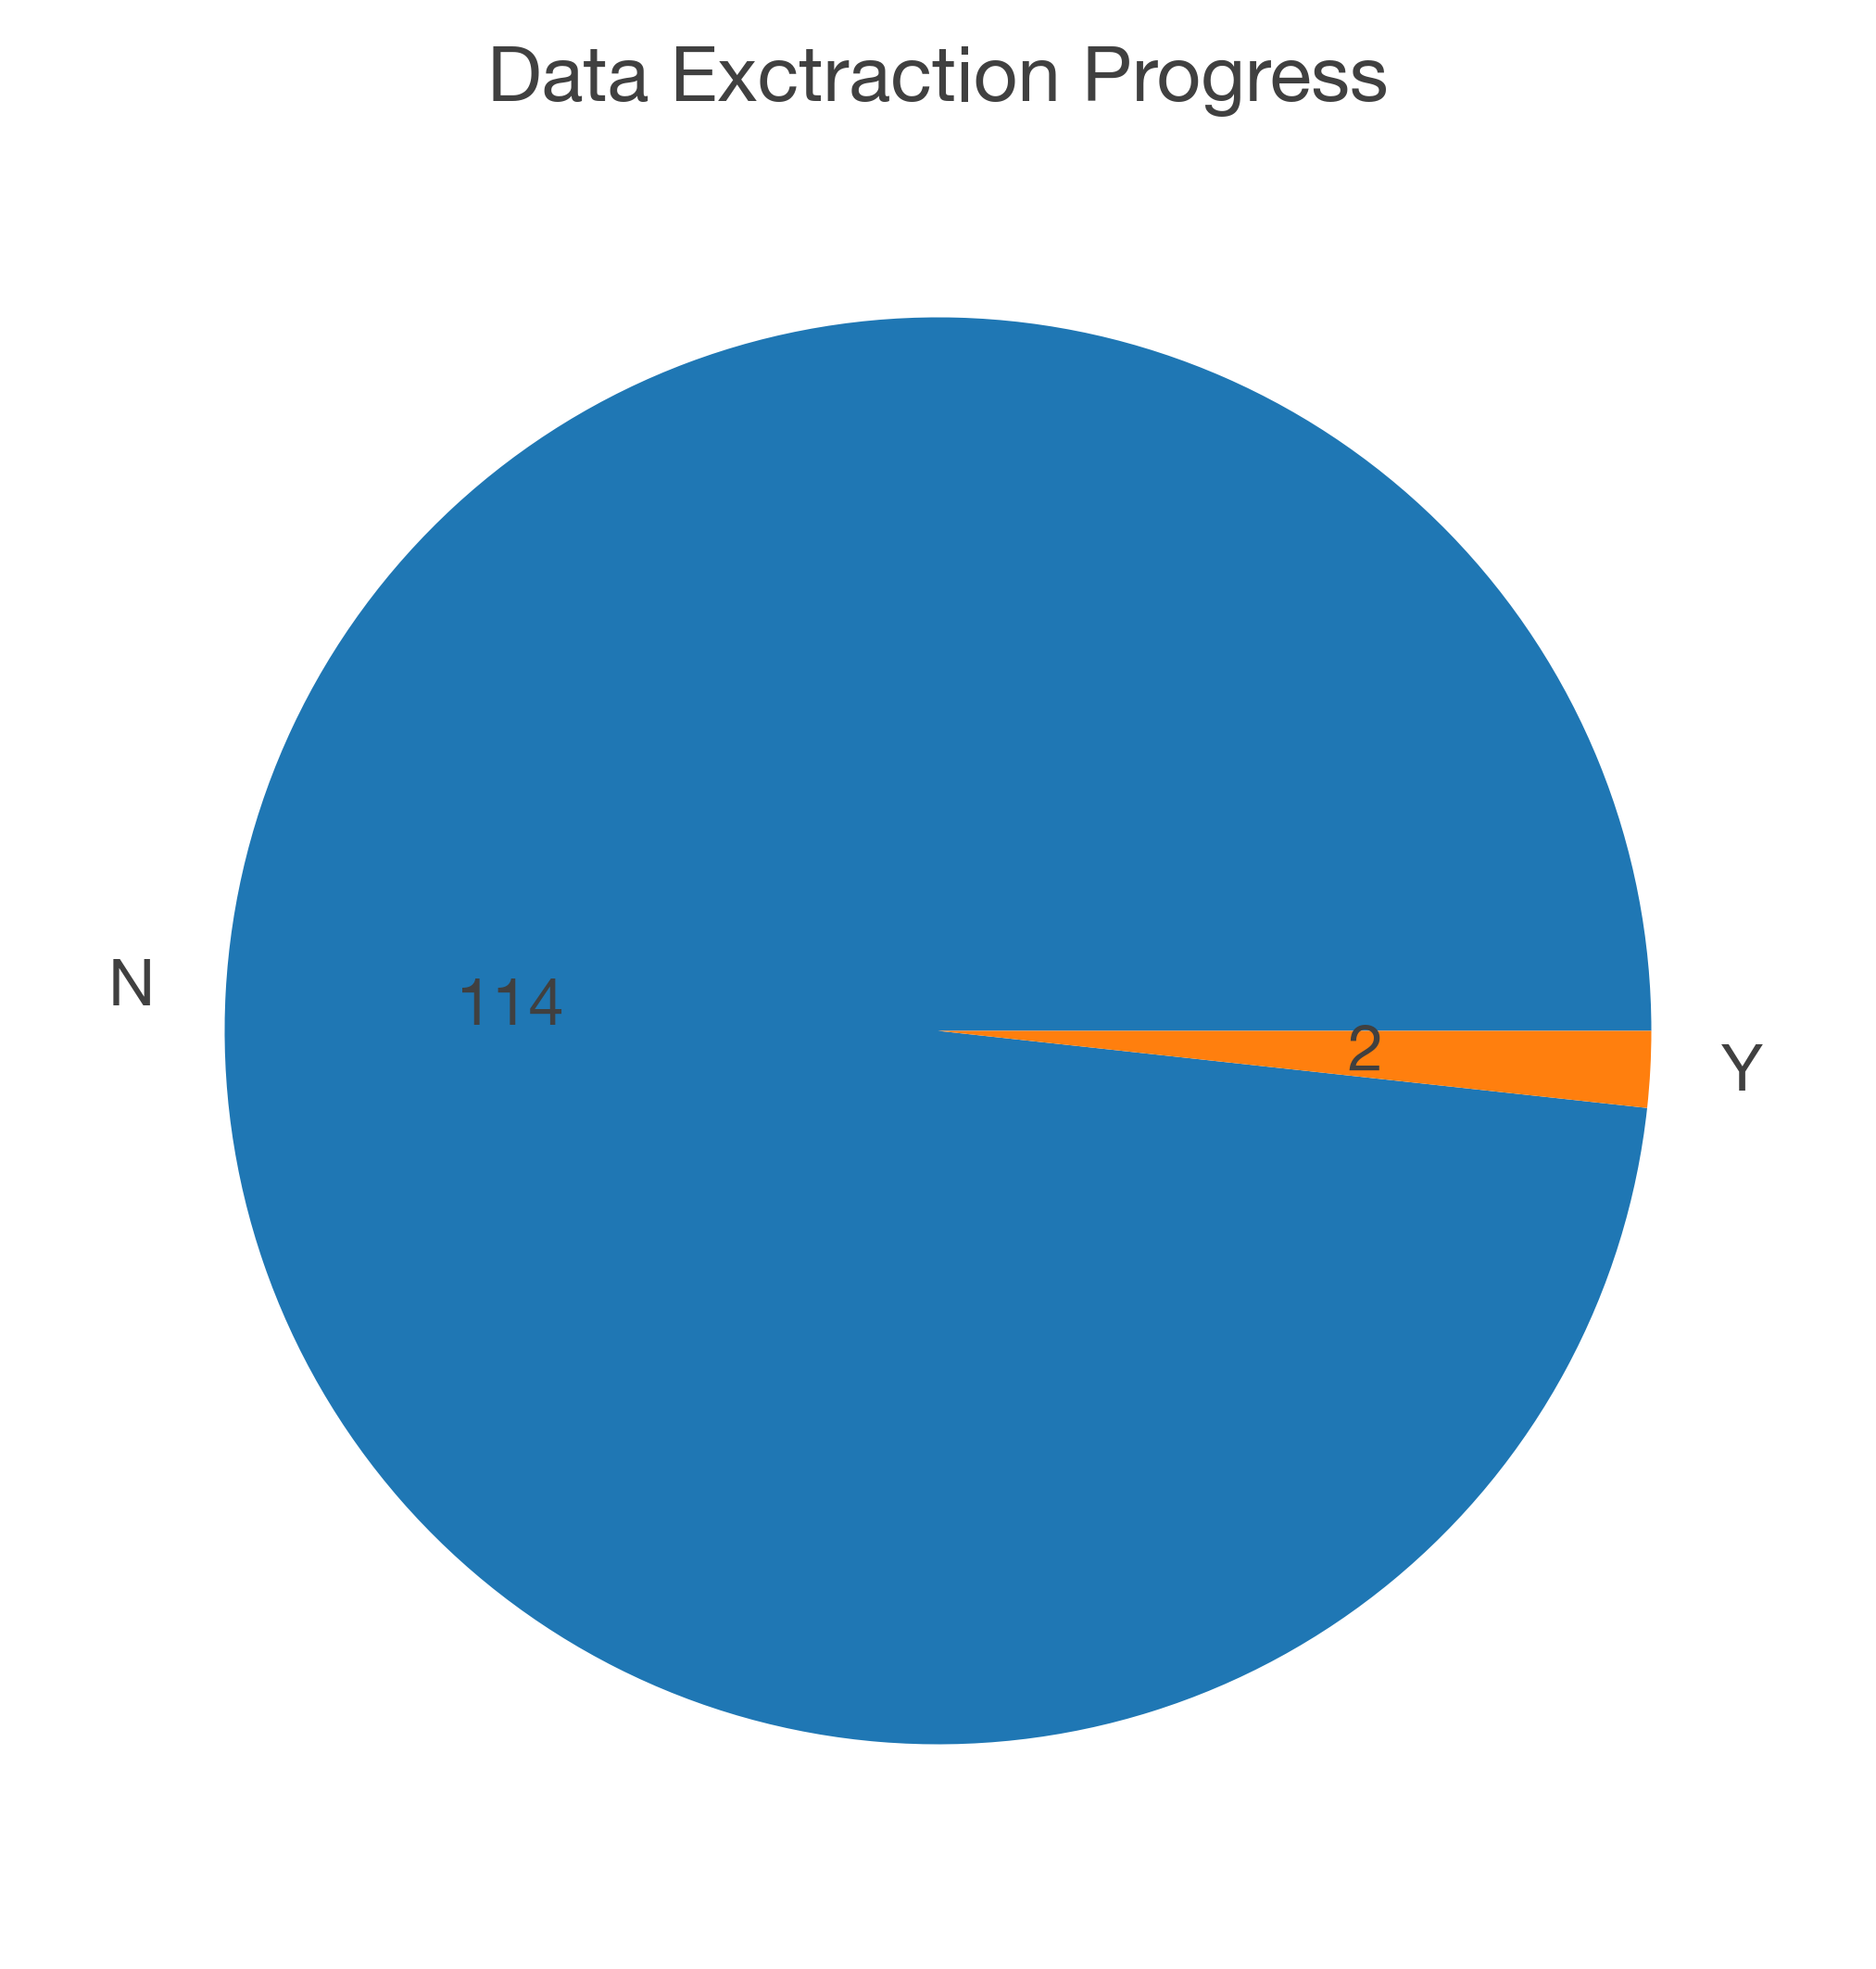

In [209]:
data_extraction_progess.columns = ['Data Extracted', 'Count']
plt.figure(figsize=(10,5))
plt.pie(x=data_extraction_progess['Count'],
    labels=data_extraction_progess['Data Extracted'],
    autopct=lambda p: f'{p * sum(data_extraction_progess["Count"]) / 100:.0f}')
plt.title('Data Exctraction Progress')
plt.show()